In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Load data

In [5]:
df = pd.read_excel('vizathon-final.xlsx')

In [14]:
### preview data
df.head()

,game_id,season,day_num,date,team_id,team_name,team_city,team_state,team_dist_from_home,opp_team_id,...,opp_blks,opp_pfs,opp_poss,opp_elo_before_game,opp_elo_after_game,opp_elo_win_prob,team_off_eff,team_def_eff,opp_off_eff,opp_def_eff
0,2003_2002-12-16_1337_1350,2003,42,2002-12-16,1337,Pepperdine,Malibu,CA,,1350,...,4,24,55,709.824755,697.340523,0.520176,107.792208,100.000000,100.000000,107.792208
1,2003_2002-12-16_1337_1350,2003,42,2002-12-16,1350,Richmond,Richmond,VA,,1337,...,2,18,58,704.564412,717.048645,0.479824,100.000000,107.792208,107.792208,100.000000
2,2003_2002-12-17_1153_1332,2003,43,2002-12-17,1153,Cincinnati,Cincinnati,OH,,1332,...,1,17,53,760.028215,744.627167,0.641710,101.315789,68.421053,68.421053,101.315789
3,2003_2002-12-17_1153_1332,2003,43,2002-12-17,1332,Oregon,Eugene,OR,,1153,...,2,16,61,722.062511,737.463558,0.358290,68.421053,101.315789,101.315789,68.421053
4,2003_2002-12-17_1257_1184,2003,43,2002-12-17,1184,E Kentucky,Richmond,KY,,1257,...,6,17,57,725.007502,734.190077,0.617393,84.000000,138.666667,138.666667,84.000000


In [15]:
### look at data types and check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184940 entries, 0 to 184939
Data columns (total 57 columns):
game_id                 184940 non-null object
season                  184940 non-null int64
day_num                 184940 non-null int64
date                    184940 non-null object
team_id                 184940 non-null int64
team_name               184940 non-null object
team_city               184940 non-null object
team_state              184940 non-null object
team_dist_from_home     184940 non-null object
opp_team_id             184940 non-null int64
opp_team_name           184940 non-null object
opp_team_city           184940 non-null object
opp_team_state          184940 non-null object
opp_dist_from_home      184940 non-null object
team_win                184940 non-null int64
score_difference        184940 non-null int64
team_location           184940 non-null object
team_score              184940 non-null int64
team_fgm                184940 non-null int64
team

No null values. Most data is numeric form. Some are strings (location, game-id, etc.). Some could be converted to numeric possibly, such as 'team_dist_from_home'.

Our target is going to be 'team_win'. It takes values 0 or 1.

In [71]:
df['team_win']

0         1
1         0
2         1
3         0
4         0
         ..
184935    1
184936    0
184937    1
184938    0
184939    1
Name: team_win, Length: 184940, dtype: int64

Transform date column to datetime format

In [139]:
df['date'] = pd.to_datetime(df['date'])

In [18]:
### checking that the ELO win probabilities sum to 1
df[['team_elo_win_prob', 'opp_elo_win_prob']]

,team_elo_win_prob,opp_elo_win_prob
0,0.479824,0.520176
1,0.520176,0.479824
2,0.358290,0.641710
3,0.641710,0.358290
4,0.382607,0.617393
...,...,...
184935,0.550405,0.449595
184936,0.570711,0.429289
184937,0.429289,0.570711
184938,0.338445,0.661555


In [69]:
comb = df['team_elo_win_prob'] + df['opp_elo_win_prob']
print(comb.min())
print(comb.max())

0.9999999999999989
1.000000000000001


OK, so the sums are all very close to 1, and the two columns make sense.

How many unique teams are there?

In [82]:
n_teams = len(df.team_id.unique())
print("Number of teams: ", n_teams)

Number of teams:  360


How many matches did each team play?

count    360.000000
mean     513.722222
std       93.353138
min        1.000000
25%      514.000000
50%      538.000000
75%      557.000000
max      586.000000
Name: game_id, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x13172bf28>,
 'caps': [<matplotlib.lines.Line2D at 0x131641400>,
 'boxes': [<matplotlib.lines.Line2D at 0x13172b7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x131641978>],
 'fliers': [<matplotlib.lines.Line2D at 0x11dfee860>],
 'means': []}

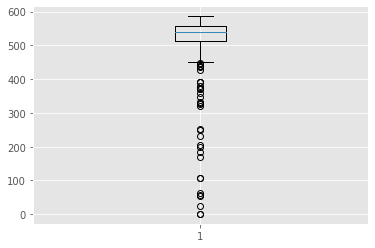

In [117]:
team_appearances = df.groupby('team_id').count().iloc[:,0]
print(team_appearances.describe())
plt.boxplot(team_appearances)


Plenty of outliers on the lower end

(array([  5.,   3.,   1.,   4.,   2.,   5.,   8.,   9., 103., 220.]),
 array([  1. ,  59.5, 118. , 176.5, 235. , 293.5, 352. , 410.5, 469. ,
        527.5, 586. ]),
 <a list of 10 Patch objects>)

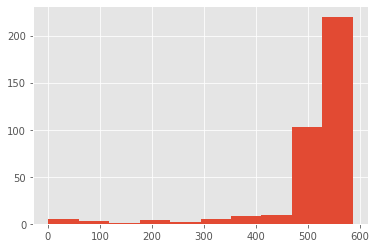

In [119]:
# another view
plt.hist(team_appearances)

How can we see a teams record at the time of a match? 
Have to access both the TeamID and the Opposing TeamID

In [127]:
wins = df.groupby('team_id').agg(sum)['team_win']
wins

team_id
1101     78
1102    243
1103    364
1104    324
1105    151
       ... 
1464    148
1465     29
1466     18
1467     34
1468      0
Name: team_win, Length: 360, dtype: int64

In [131]:
df[df['team_win'] == 0].groupby('team_id').count().iloc[:,0]

team_id
1101    106
1102    278
1103    198
1104    238
1105    340
       ... 
1464    337
1465     24
1466     39
1467     29
1468      2
Name: game_id, Length: 360, dtype: int64

0        2002-12-16
1        2002-12-16
2        2002-12-17
3        2002-12-17
4        2002-12-17
            ...    
184935   2002-12-15
184936   2002-12-15
184937   2002-12-15
184938   2002-12-15
184939   2002-12-15
Name: date, Length: 184940, dtype: datetime64[ns]

### Feature selection / Engineering

Some features are obviously not going to be available for new games. You will just have team names, their prior history, and possibly location data about the game